<a href="https://colab.research.google.com/github/merongedrago/Explainable-Techniques-II/blob/main/explainable_techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explainable Techniques II
### Prepared By Meron Gedrago

## Part 1: import dataset and create a model

In [2]:
# code from Dr. Bent's notebook
# import necessary libraries
# uncomment the next line if the following are not installed
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
#!pip install ucimlrepo
#!pip install category_encoders

# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
import xgboost as xgb
import category_encoders as ce
import seaborn as so
import warnings
warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-9mkj1nn8/alepython_99ebbe14bca5424085f84b965e380d2d
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-9mkj1nn8/alepython_99ebbe14bca5424085f84b965e380d2d
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.8 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350ab6-py3-none-any.whl size=15251 sha256=3d6b0199340621a28523cb8fdfd60cdaea20f1eb7b3a819f73ecd0c8b7b14dbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbwf_nt7/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython


In [3]:
# import dataset from UCI
# source: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

from ucimlrepo import fetch_ucirepo

# fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

# data (as pandas dataframes)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets

# metadata
print(online_shoppers_purchasing_intention_dataset.metadata)

# variable information
print(online_shoppers_purchasing_intention_dataset.variables)

{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'ID': 367, 'type': 'NATIVE', 'title': 'Real-time prediction of online shoppers’ pur

In [4]:
# from the variable information - https://link.springer.com/article/10.1007/s00521-018-3523-0/tables/1)
# Month, VisitorType, OperatingSystems, Browser, Region, TrafficType, Weekend are categorical features
cat_vars = [
    "Month",
    "VisitorType",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "Weekend",
]
for var in cat_vars:
    X[var] = X[var].astype("category")
encoder = ce.OneHotEncoder(cols=cat_vars)

# divide training and test data - decided to use 50-50 split like the code from Dr. Bent for optimization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, random_state=42
)

### Correlation matrix

In [6]:
# look at the correlation between numerical features
num_features = []
for column in X_train.columns:
    if X_train[column].dtype == "int64" or X_train[column].dtype == "float64":
        num_features.append(column)
corr_matrix = X_train[num_features].corr()
print(corr_matrix)

                         Administrative  Administrative_Duration  \
Administrative                 1.000000                 0.594795   
Administrative_Duration        0.594795                 1.000000   
Informational                  0.379130                 0.278720   
Informational_Duration         0.263605                 0.185311   
ProductRelated                 0.428270                 0.253903   
ProductRelated_Duration        0.390625                 0.284898   
BounceRates                   -0.222106                -0.142576   
ExitRates                     -0.315347                -0.204376   
PageValues                     0.103065                 0.083911   
SpecialDay                    -0.081113                -0.063213   

                         Informational  Informational_Duration  \
Administrative                0.379130                0.263605   
Administrative_Duration       0.278720                0.185311   
Informational                 1.000000               

<Axes: >

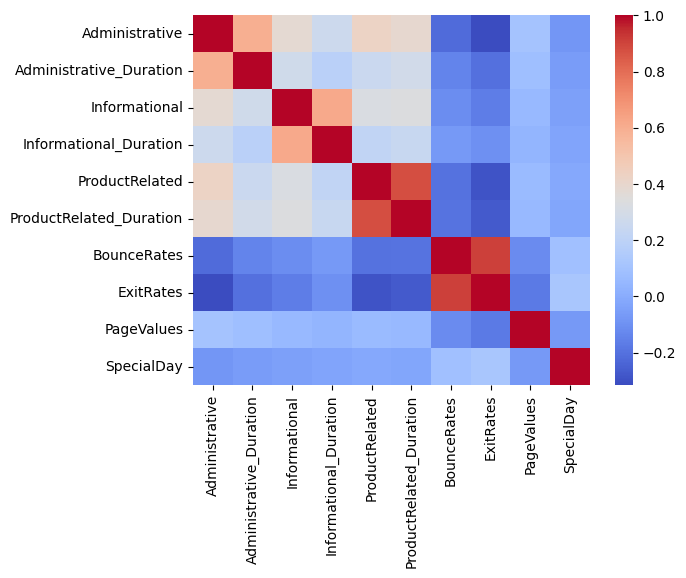

In [7]:
# display the correlation matrix as heatmap
so.heatmap(corr_matrix, cmap="coolwarm")

From the correlation matrix, there are no concerning correlations between variables. However, there are weak to medium correlations among related features, such as Administrative and Administrative Duration (pages visited vs. time spent on admin-related pages). Similar trends appear for Bounce Rate and Exit Rate, as well as Product Related and Product Related Duration.  

Since we will be applying PDP and ALE plots, it will be interesting to compare the differences between these two methods for such correlated variables.  

To keep the plots manageable and the interpretations more meaningful, I will apply PDP and ALE plots only to the numerical variables.  

*The above markdown was edited with ChatGPT 5 at September 29 1:30 AM. It was used to fix grammatical errors*

In [8]:
# encode categorical features befoer fitting the model
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [9]:
# fit an XGboost model to predict whether a visitor will make a purhcase
# or not when visiting a website using different features
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# prep the test data with same encoding
X_test = encoder.transform(X_test)
# check the accuracy of the model
print(
    f"""The accuracy of the model of the XGBoost classifier is
{round (model.score(X_test, y_test),4)} when predicting whether or not
a visitor will make a purchase on the website using the variables in the dataset.
"""
)

The accuracy of the model of the XGBoost classifier is
0.8947 when predicting whether or not 
a visitor will make a purchase on the website using the variables in the dataset. 



## Part 2: Perform explainable techniques II

### Partial Dependence Plots

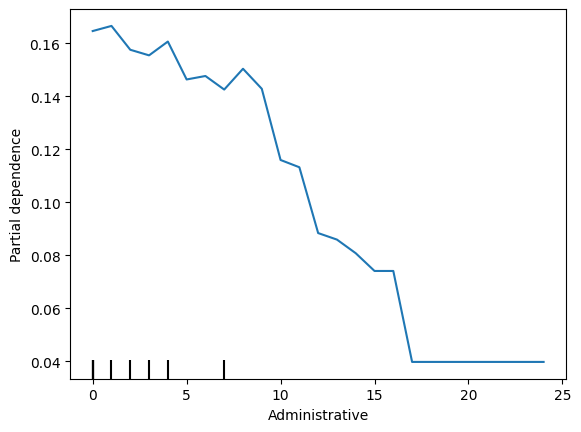

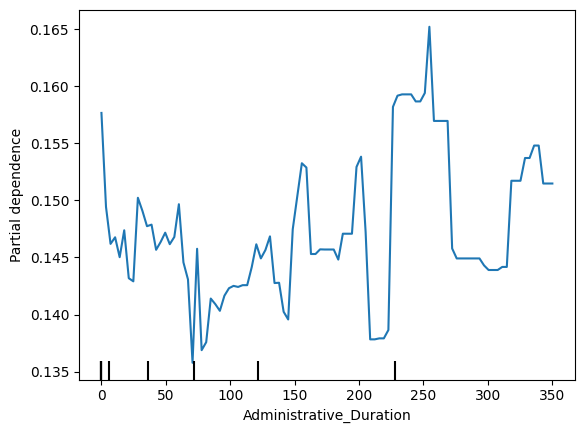

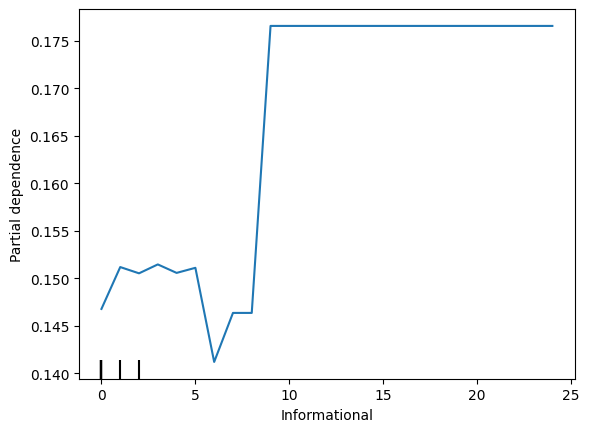

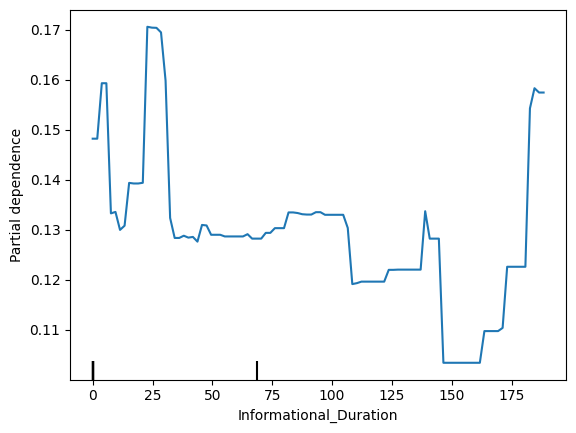

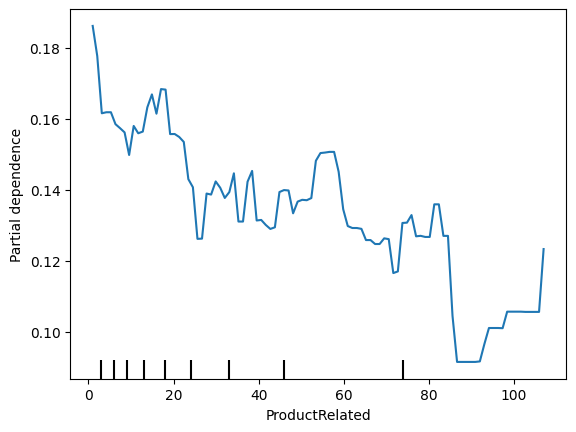

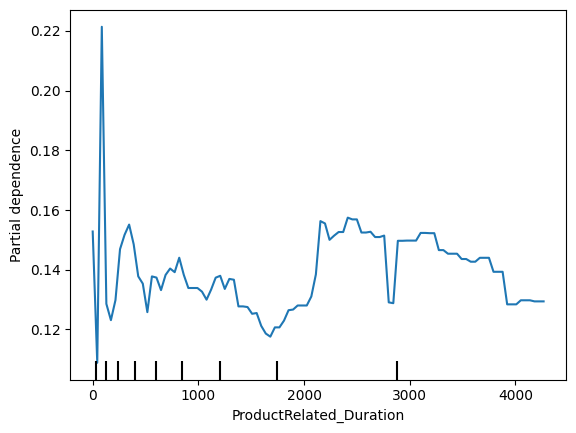

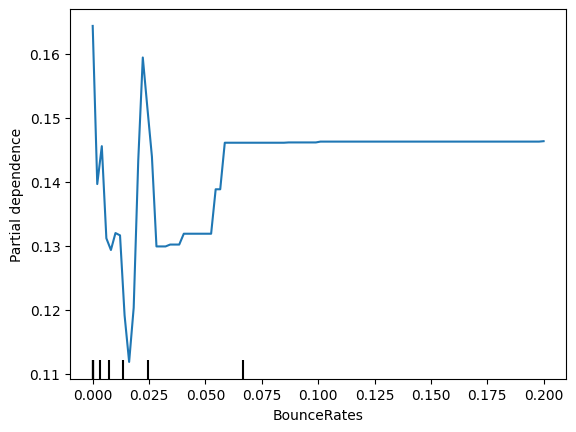

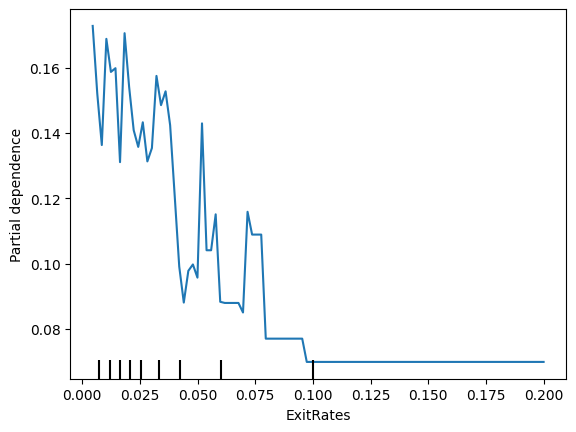

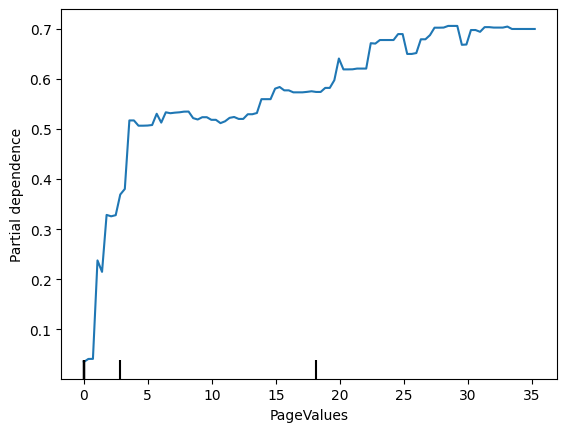

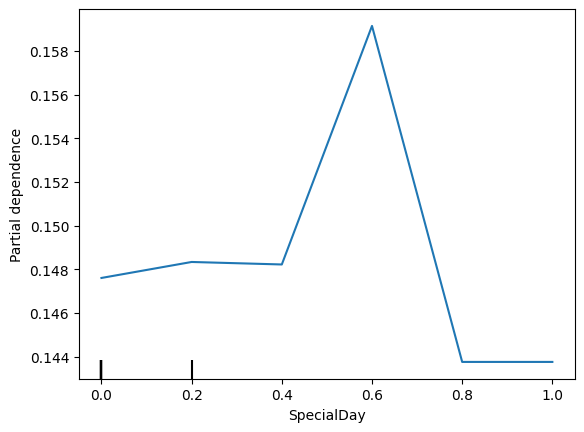

In [11]:
# loop through each numerical feature
for feature in num_features:
    # Use PartialDependenceDisplay to plot PDP
    display = PartialDependenceDisplay.from_estimator(
        model, X_test, [feature], kind="average"
    )
    # uncomment the next line to standardize the y-axis for all the plots
    # display.plot(pdp_lim={1: (0, 0.7)})

### Interpretation

A detailed description of each variable can be found [here](https://link.springer.com/article/10.1007/s00521-018-3523-0/tables/1).

- Administrative (Number of pages visited by the visitor about account management): From the PDP plot, we see a sharp decrease as the count increases. It peaks around 7–8 but then declines. This makes sense because opening account pages multiple times does not necessarily mean someone will make a purchase.  

- Administrative Duration (Total time in seconds spent by the visitor on account management pages): Similar to the Administrative variable, there is a peak around 200–250 seconds, followed by a sharp decline before stabilizing. This reflects the typical time needed to check out and pay for items.  

- Informational (Number of pages visited about website, communication, and address information): There is a sharp increase in purchase probability once the number reaches about 10 pages, after which it plateaus.  

- Informational Duration (Total time in seconds spent on informational pages)  
  Unlike Informational, Informational Duration has two peaks: a sharp increase in purchase probability around the 100-second mark, a slight dip, and then another sharp rise after about 175 seconds.  

- Product Related (Number of product-related pages visited): This is not completely linear, but the overall trend shows decreasing purchase probability as more pages are visited, suggesting visitors may just be "window shopping."  

- Product Related Duration (Total time in seconds spent on product-related pages): There is a sharp increase in purchase probability under 100 seconds, likely reflecting decisive buyers. Beyond that, probabilities fluctuate but remain generally higher once time exceeds 2000 seconds, likely indicating that heavily invested shoppers eventually decide to buy something before leaving.  

- Bounce Rate (Average bounce rate of visited pages): Purchase probability fluctuates at very low bounce rates but stabilizes once the rate reaches around 0.7.  

- Exit Rate (Average exit rate of visited pages): Purchase probability gradually decreases as exit rate increases. This makes sense as the quicker or more often visitors leave, the less likely they are to buy.  

- Page Value (Average business value of visited pages): As page value increases, so does purchase probability. This is intuitive since higher-value pages are those that customers are most interested in.  

- Special Day (Closeness of visit date to a special day): There is a spike in purchase probability in the middle range. People tend to buy not too close to the holiday (to allow for delivery) but also not too early, when they have not yet started thinking about gifts.  

*The above markdown was edited with ChatGPT 5 at September 29 12:10 AM. It was used to fix grammatical errors*

### ICE Plots

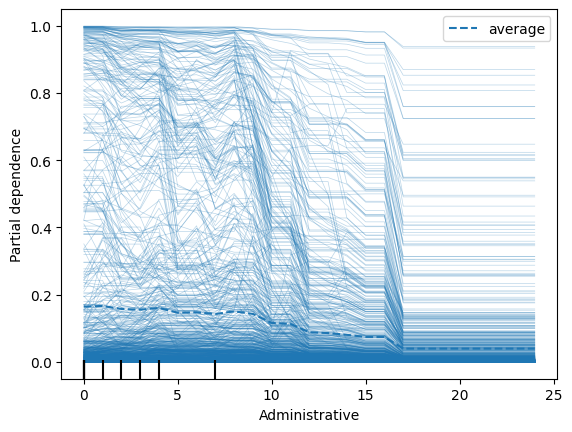

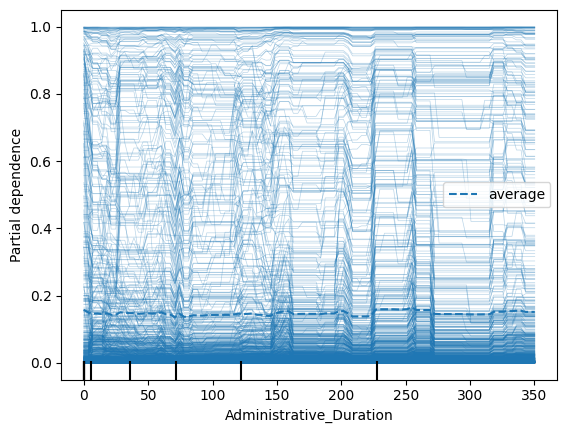

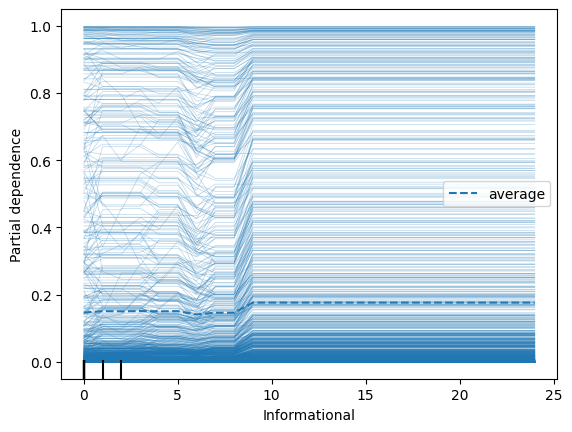

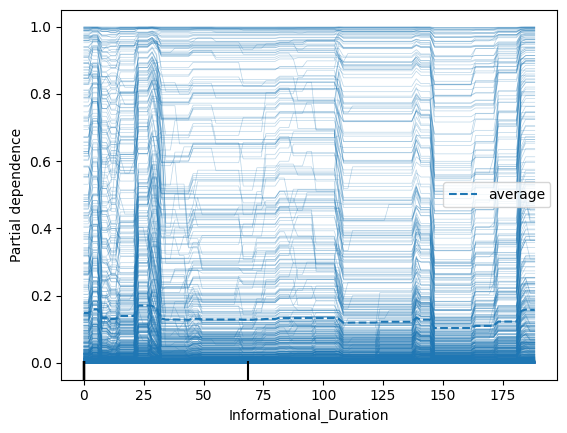

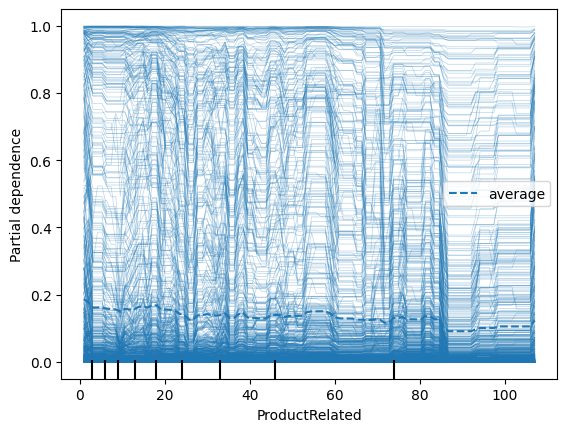

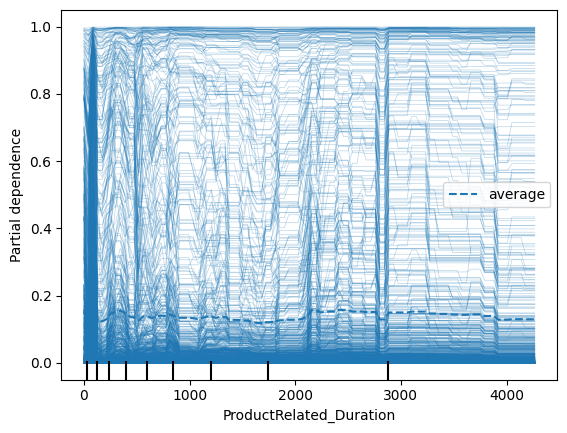

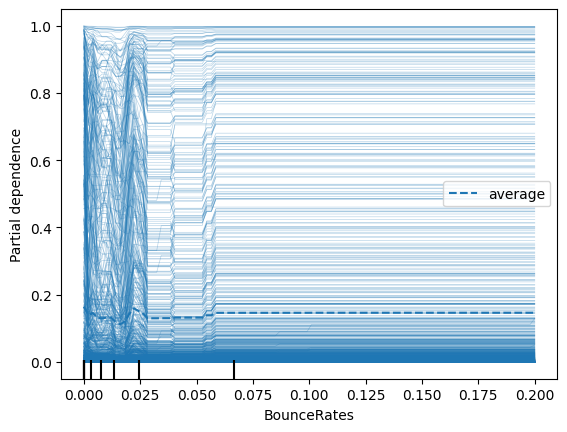

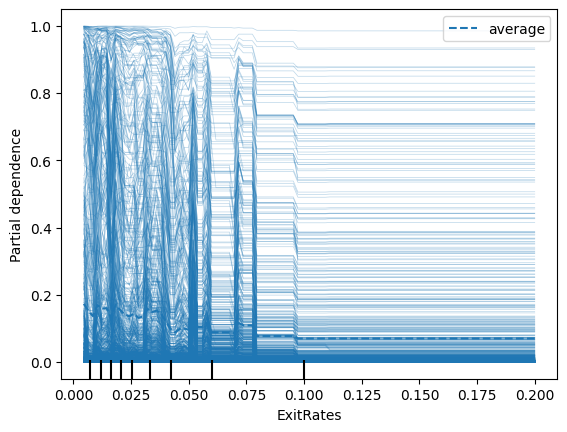

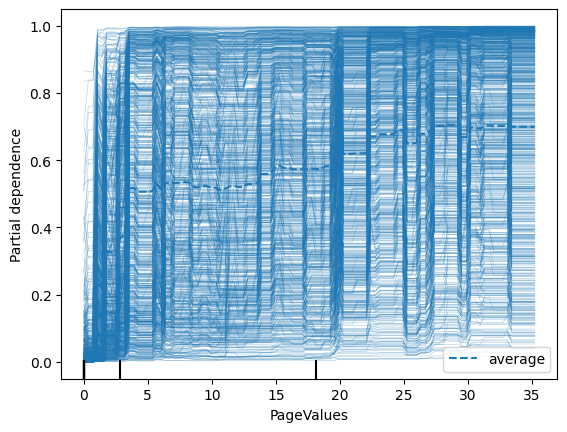

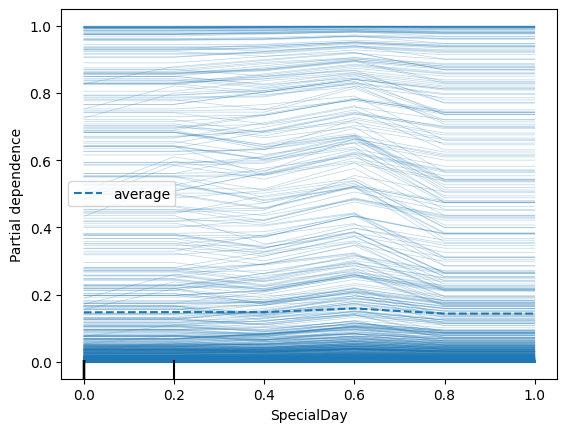

In [12]:
# ICE plots
for feature in num_features:
    # Use PartialDependenceDisplay to plot PDP
    display = PartialDependenceDisplay.from_estimator(
        model, X_test, [feature], kind="both"
    )
    # uncomment the next line to standardize the y-axis for all the plots
    # display.plot(pdp_lim={1: (0, 0.7)})

### Interpretation
The interpretation for ICE plots are similar to those of PDP plots are we see the same trend across both of the plots but PDP take the average while ICE plots shows each variations.

### Accumulated Local Effects (ALE) Plots

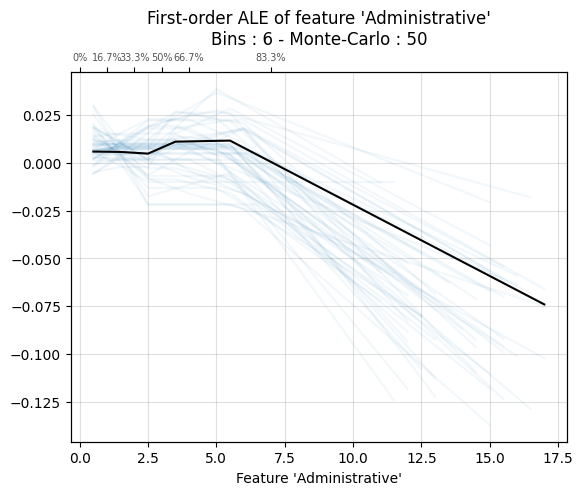

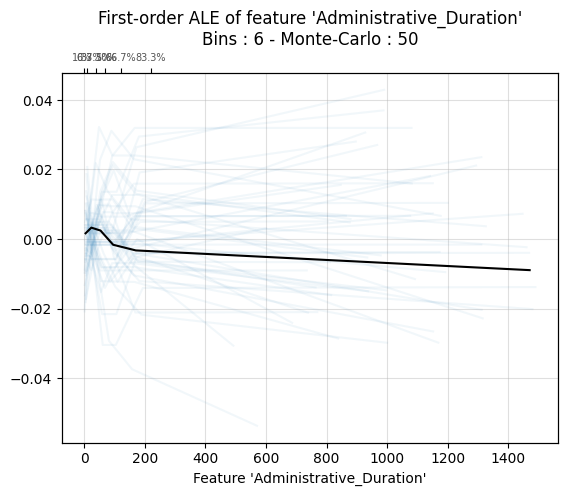

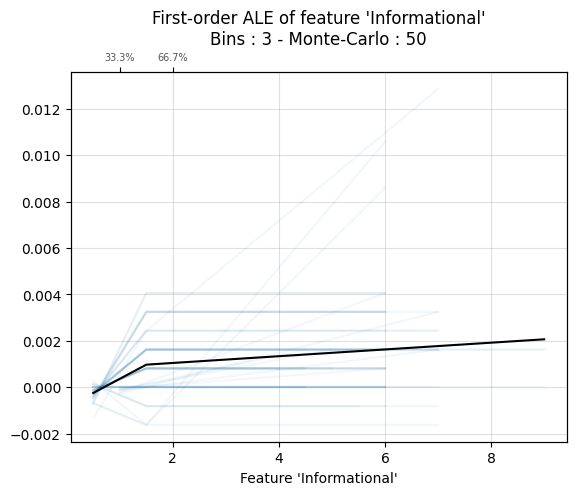

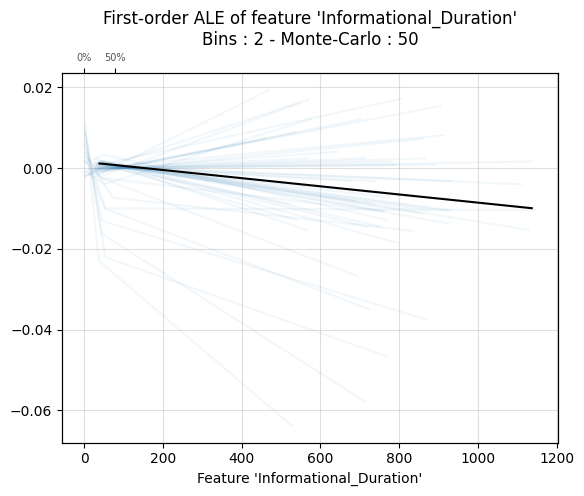

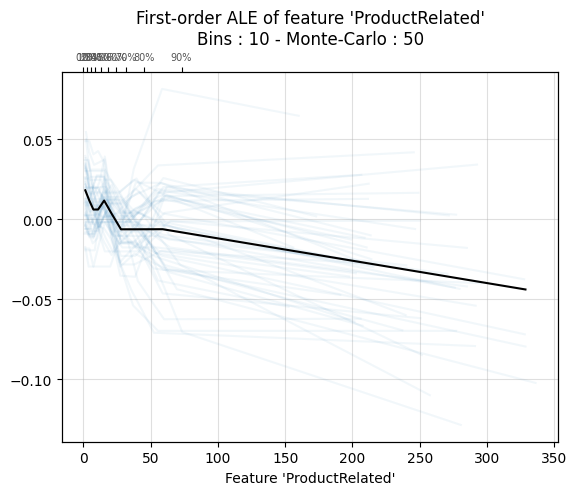

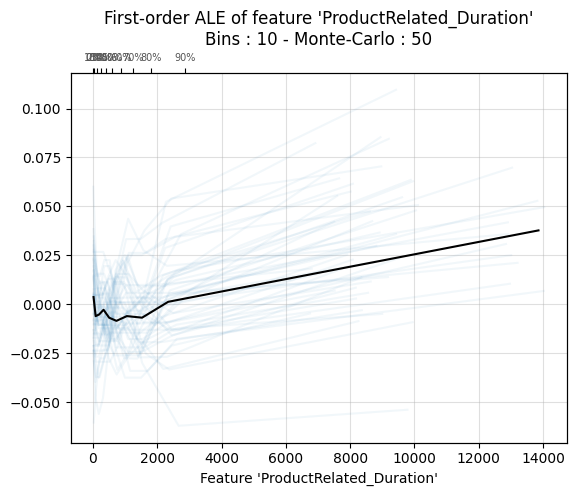

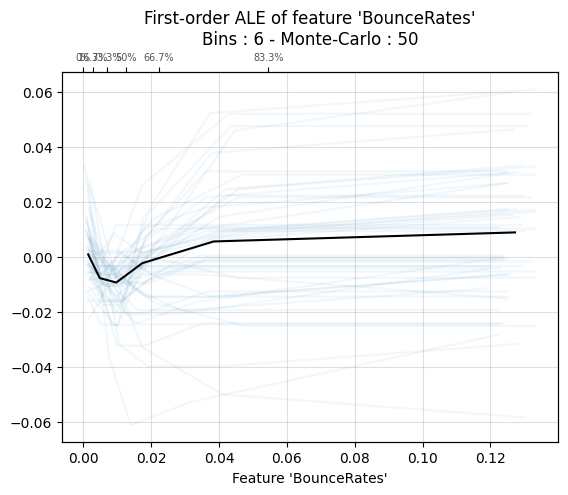

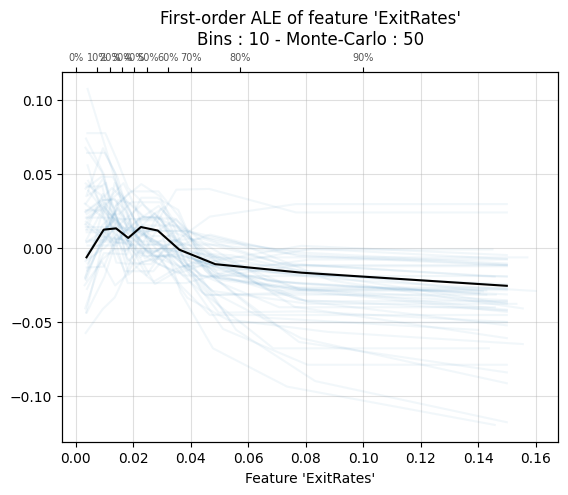

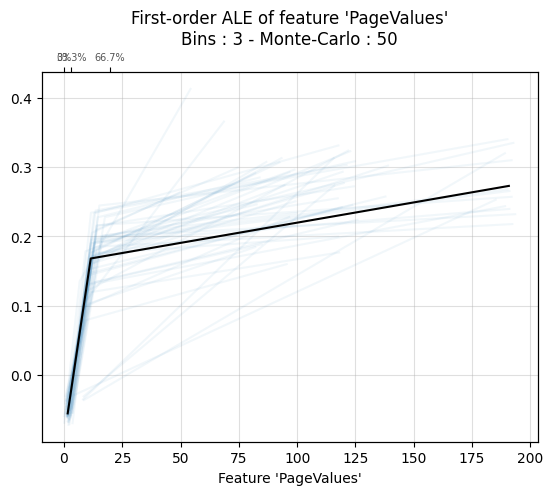

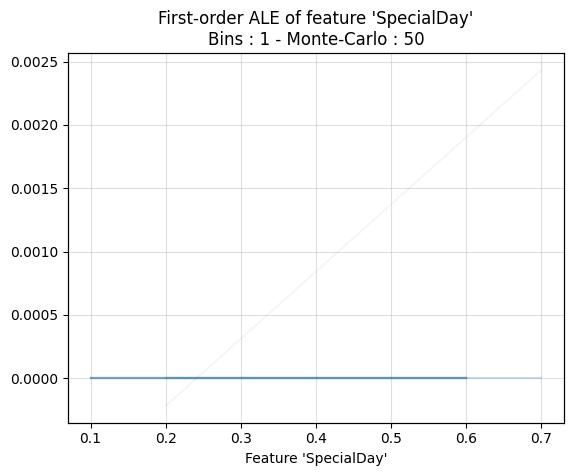

In [13]:
for feature in num_features:
    # Use default parameters for 1D Main Effect ALE Plot
    ale_plot(model, X_train, [feature], monte_carlo=True)

### Interpretation

- Administrative: Similar to the PDP plot, there is a steady decrease as the Administrative feature increases.  
- Administrative Duration : Like the PDP plot, there is a peak at lower durations followed by a slight decline.  
- Informational: Similar to the PDP plot, there is a sharp increase at lower values, but afterward the probability increases very slowly as the values rise.  
- Informational Duration: Unlike the PDP plot, which showed a peak, here there is a steady, slow decrease in purchase probability as duration increases.  
- Product Related: As in the PDP plot, there is a spike at lower values. However, contrary to the PDP, the trend here shows a steady, slow decrease afterward.  
- Product Related Duration: Very similar to the PDP plot, there is a spike at lower durations followed by a gradual but steep increase as time increases.  
- Bounce Rate: Purchase probability fluctuates at very low bounce rates but then stabilizes, consistent with the PDP plot.  
- Exit Rate: Unlike the PDP plot, there is an initial increase, followed by a very slow decrease as exit rates rise.  
- Page Value: There is a sharp increase at lower values, followed by a steadier, slower increase not observed in the PDP plot.  
- Special Day: Contrary to the PDP plot, this one appears flat, indicating little to no impact from Special Day.  

*The above markdown was edited with ChatGPT 5 at September 29 1:20 AM. It was used to fix grammatical errors*